# 05 - Machine Learning and Deep Learning Modeling

This notebook applies machine learning and deep learning models to forecast energy production, consumption, and grid import/export using engineered features.

**Models covered:**
- Random Forest Regressor
- XGBoost Regressor


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')


In [3]:
# Load the processed feature data
df = pd.read_csv('../data/processed/hourly_features_data.csv', parse_dates=['timestamp'], index_col='timestamp')

# Define target columns
targets = [
    'Energy Produced (Wh)',
    'Energy Consumed (Wh)',
    'net_export_import_grid'
]

# Drop non-numeric or ID columns if present
X = df.drop(columns=targets).select_dtypes(include=[np.number])


In [4]:
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))
    return {"MAE": mae, "RMSE": rmse, "SMAPE": smape, "R2": r2}


In [5]:
results = []

for target in targets:
    print(f"\n{'='*30}\nModeling: {target}\n{'='*30}")
    y = df[target]

    # Time-aware train/test split
    split_idx = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Random Forest
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_preds = rf_model.predict(X_test)
    rf_eval = evaluate_model(y_test, rf_preds)
    rf_eval.update({"Model": "Random Forest", "Target": target, "y_test": y_test, "y_pred": rf_preds})
    results.append(rf_eval)

    # XGBoost
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    xgb_model.fit(X_train, y_train)
    xgb_preds = xgb_model.predict(X_test)
    xgb_eval = evaluate_model(y_test, xgb_preds)
    xgb_eval.update({"Model": "XGBoost", "Target": target, "y_test": y_test, "y_pred": xgb_preds})
    results.append(xgb_eval)



Modeling: Energy Produced (Wh)

Modeling: Energy Consumed (Wh)

Modeling: net_export_import_grid


In [6]:
# Create and show results table
results_df = pd.DataFrame(results)
results_df = results_df[['Target', 'Model', 'MAE', 'RMSE', 'SMAPE', 'R2']]
print(results_df.round(2))


                   Target          Model    MAE    RMSE   SMAPE    R2
0    Energy Produced (Wh)  Random Forest  63.24  151.53   80.22  0.92
1    Energy Produced (Wh)        XGBoost  61.14  148.98  110.90  0.93
2    Energy Consumed (Wh)  Random Forest  52.47  100.23   16.95  0.94
3    Energy Consumed (Wh)        XGBoost  52.39  101.54   30.43  0.94
4  net_export_import_grid  Random Forest   0.32    0.78   47.36  0.88
5  net_export_import_grid        XGBoost   0.26    0.64   44.79  0.92


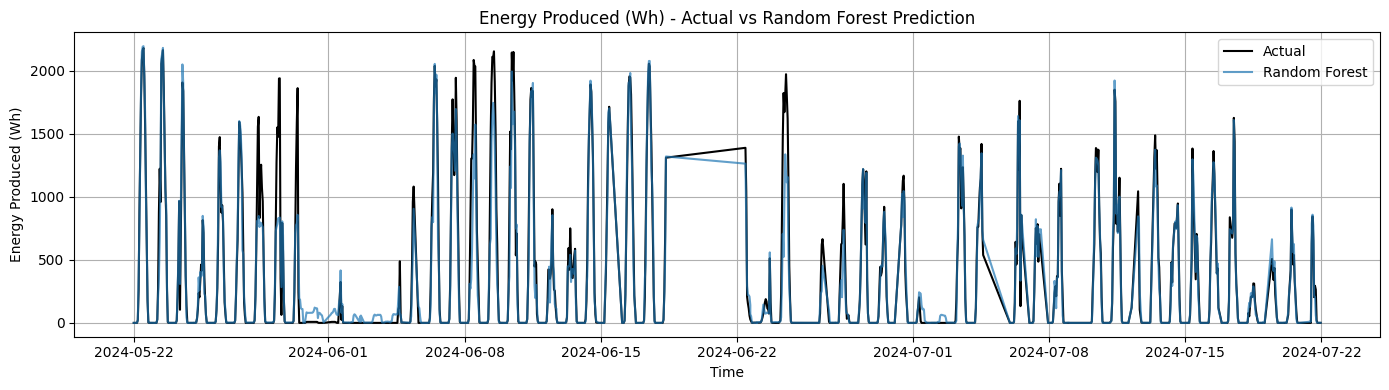

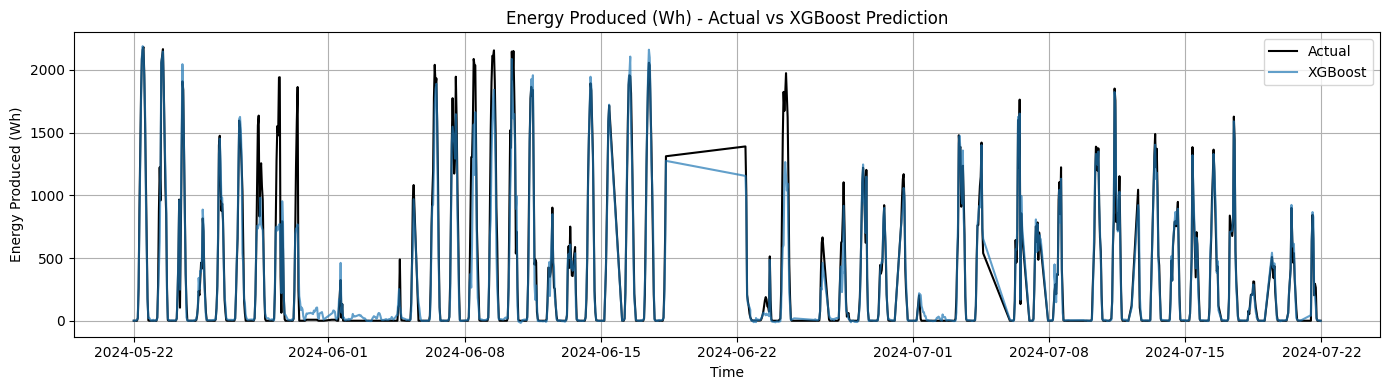

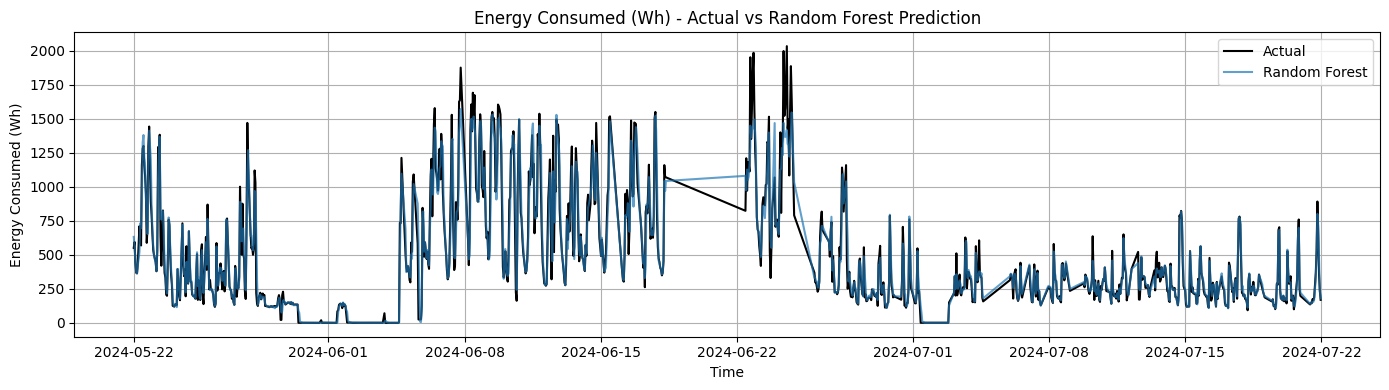

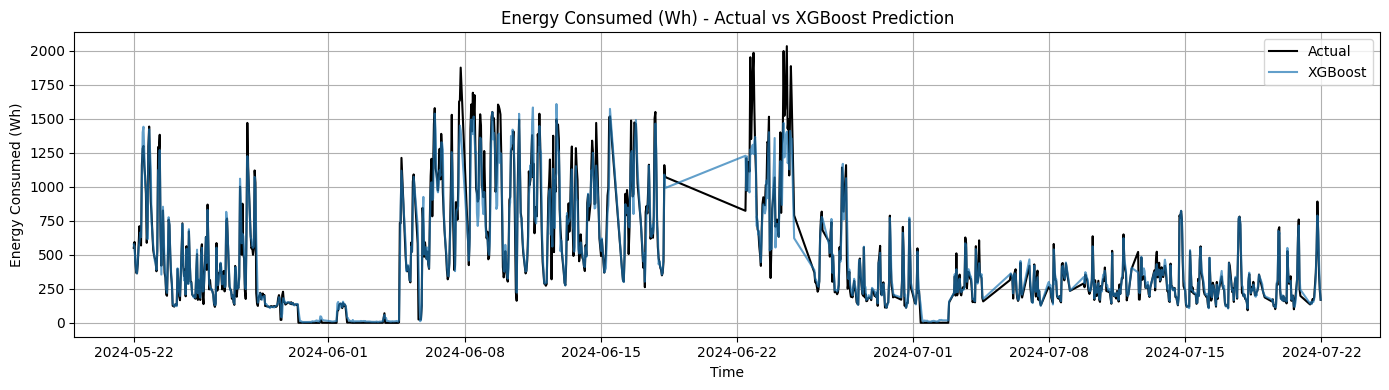

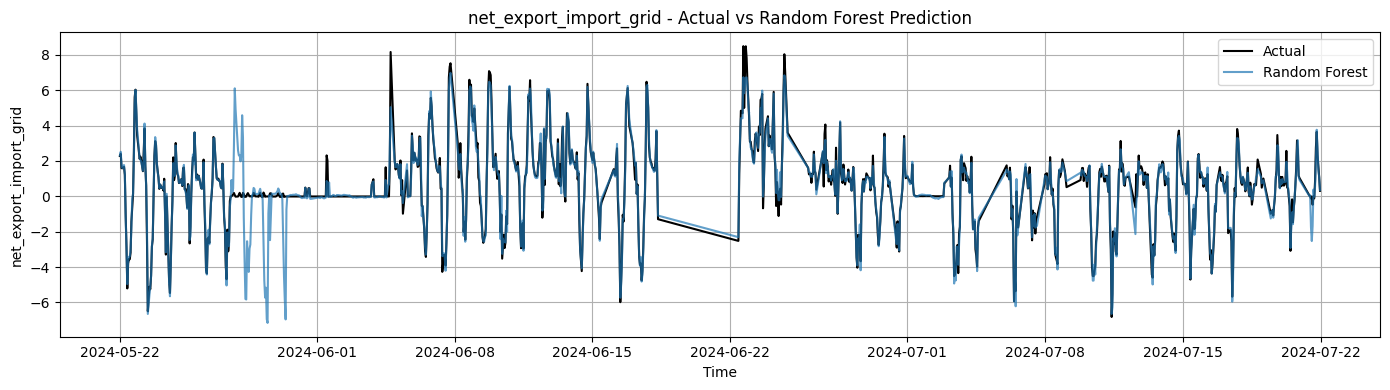

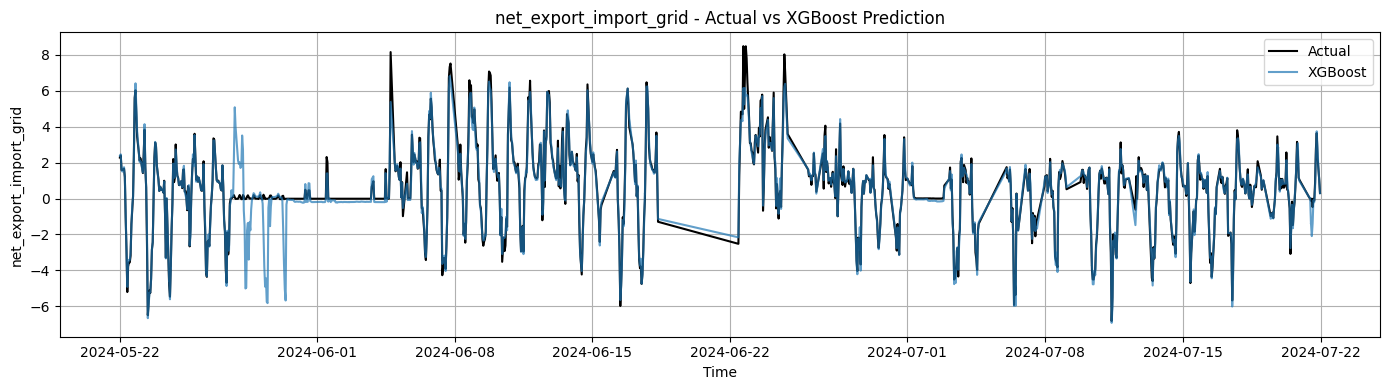

In [7]:
# Plot actual vs predicted using stored predictions
for res in results:
    plt.figure(figsize=(14, 4))
    plt.plot(res['y_test'].index, res['y_test'], label='Actual', color='black')
    plt.plot(res['y_test'].index, res['y_pred'], label=res['Model'], alpha=0.7)
    plt.title(f"{res['Target']} - Actual vs {res['Model']} Prediction")
    plt.xlabel("Time")
    plt.ylabel(res['Target'])
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



Feature importance for: Energy Produced (Wh)


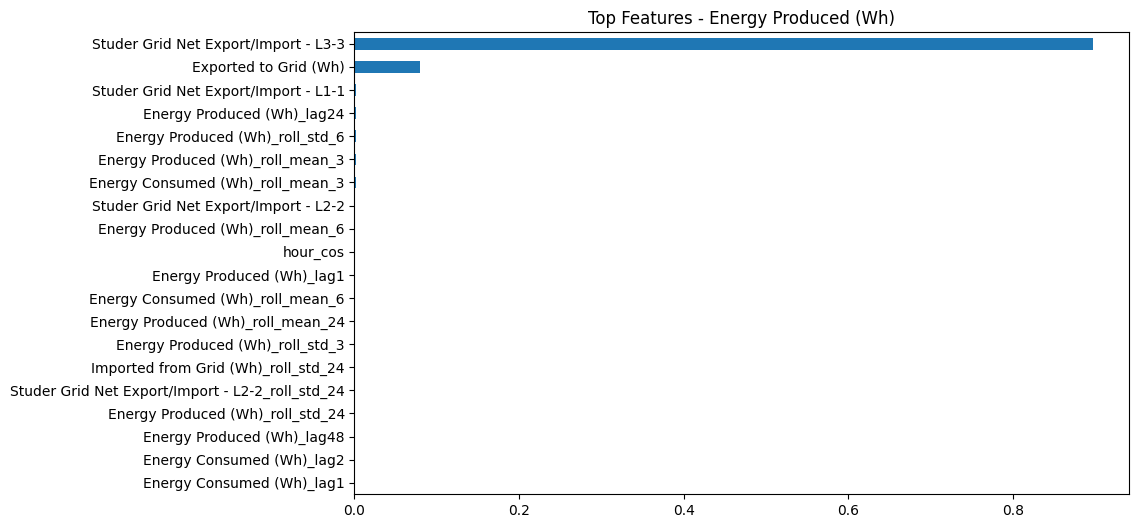


Feature importance for: Energy Consumed (Wh)


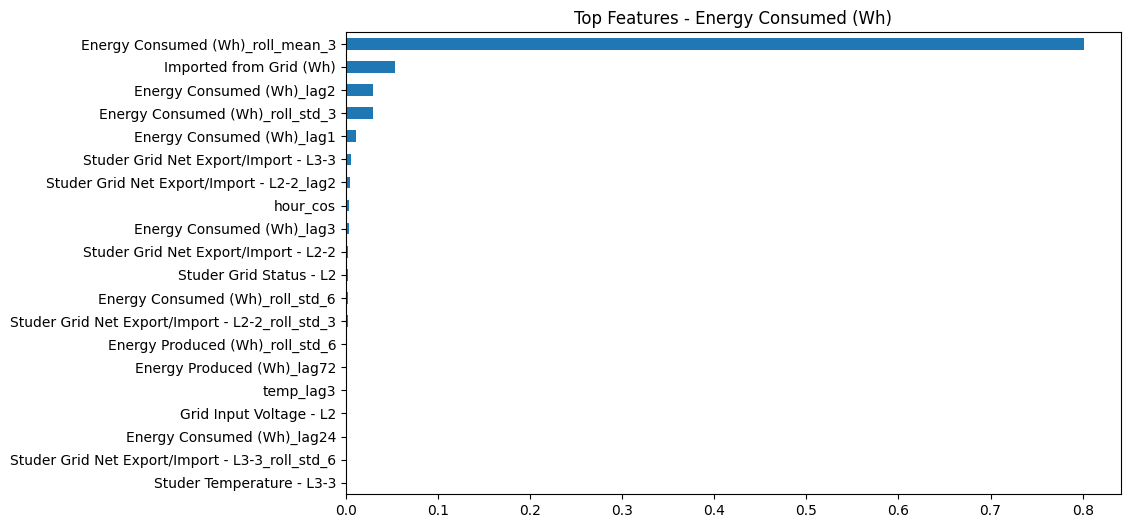


Feature importance for: net_export_import_grid


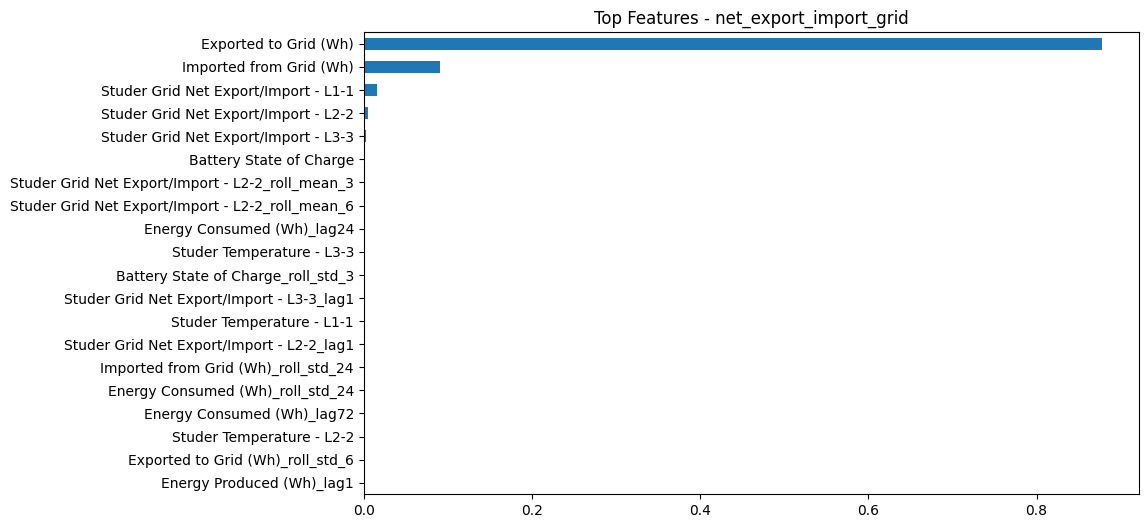

Dropped 49 features common to all targets.


In [8]:
# Drop features that are low-importance for all targets
low_importance_sets = []

for target in targets:
    print(f"\nFeature importance for: {target}")
    y = df[target]
    split_idx = int(len(df) * 0.8)
    X_train, y_train = X.iloc[:split_idx], y.iloc[:split_idx]

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    importances = pd.Series(rf.feature_importances_, index=X.columns)
    importances.sort_values(ascending=False).head(20).plot(kind='barh', figsize=(10,6), title=f"Top Features - {target}")
    plt.gca().invert_yaxis()
    plt.show()

    low_importance = set(importances[importances < 1e-4].index)
    low_importance_sets.append(low_importance)

# Take intersection across all targets
final_low_importance = set.intersection(*low_importance_sets)
X_reduced = X.drop(columns=list(final_low_importance))
print(f"Dropped {len(final_low_importance)} features common to all targets.")


In [9]:
# Tuning XGBoost on small subset
sample_target = 'Energy Produced (Wh)'
y_sample = df[sample_target]
split_idx = int(len(df) * 0.8)
X_train, y_train = X_reduced.iloc[:split_idx], y_sample.iloc[:split_idx]

xgb = XGBRegressor()
param_dist = {
    "n_estimators": [100, 200],
    "max_depth": [3, 4, 5],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0]
}
search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=5, cv=3, random_state=42, n_jobs=-1)
search.fit(X_train, y_train)

best_params = search.best_params_
print("Best params for XGBoost:", best_params)


Best params for XGBoost: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}


In [10]:
results = []

for target in targets:
    print(f"\nModeling (optimized): {target}")
    y = df[target]
    split_idx = int(len(df) * 0.8)
    X_train, X_test = X_reduced.iloc[:split_idx], X_reduced.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Random Forest (baseline)
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    rf_eval = evaluate_model(y_test, rf_pred)
    rf_eval.update({"Model": "Random Forest", "Target": target, "y_test": y_test, "y_pred": rf_pred})
    results.append(rf_eval)

    # Tuned XGBoost
    xgb_model = XGBRegressor(**best_params, random_state=42)
    xgb_model.fit(X_train, y_train)
    xgb_pred = xgb_model.predict(X_test)
    xgb_eval = evaluate_model(y_test, xgb_pred)
    xgb_eval.update({"Model": "Tuned XGBoost", "Target": target, "y_test": y_test, "y_pred": xgb_pred})
    results.append(xgb_eval)



Modeling (optimized): Energy Produced (Wh)

Modeling (optimized): Energy Consumed (Wh)

Modeling (optimized): net_export_import_grid


In [11]:
results_df = pd.DataFrame(results)
results_df = results_df[['Target', 'Model', 'MAE', 'RMSE', 'SMAPE', 'R2']]
print(results_df.round(2))


                   Target          Model    MAE    RMSE   SMAPE    R2
0    Energy Produced (Wh)  Random Forest  63.41  152.83   79.66  0.92
1    Energy Produced (Wh)  Tuned XGBoost  66.82  137.74  113.63  0.94
2    Energy Consumed (Wh)  Random Forest  51.97   98.92   16.82  0.94
3    Energy Consumed (Wh)  Tuned XGBoost  60.94   98.11   34.03  0.95
4  net_export_import_grid  Random Forest   0.32    0.78   47.42  0.88
5  net_export_import_grid  Tuned XGBoost   0.25    0.54   44.25  0.94


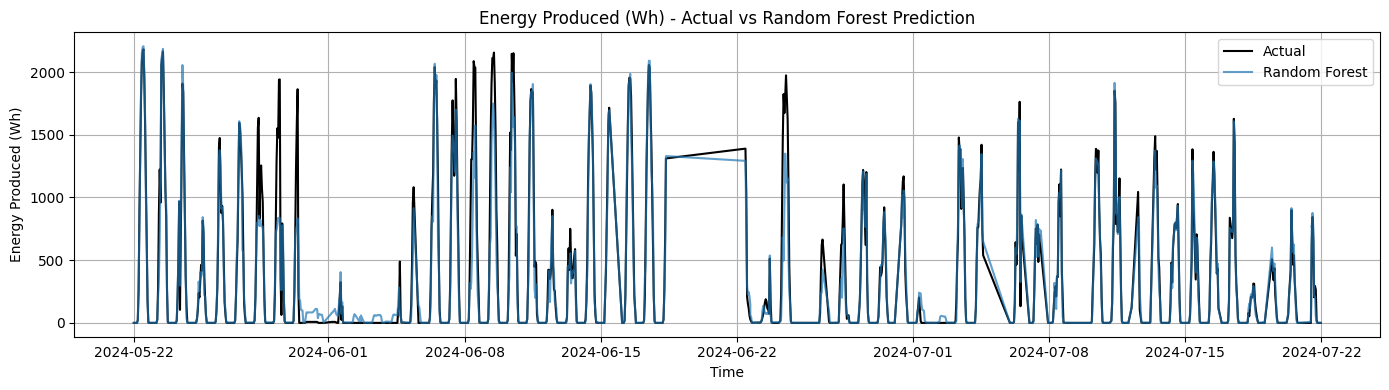

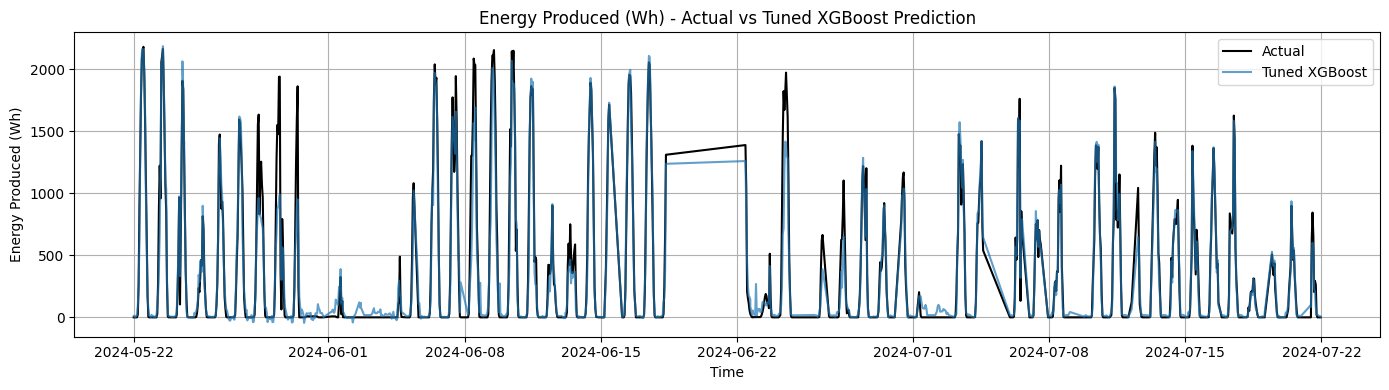

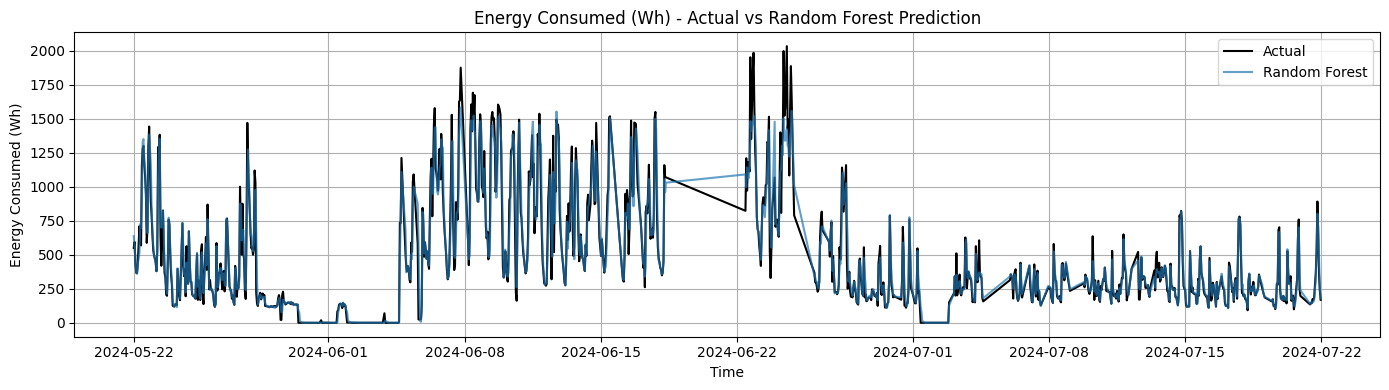

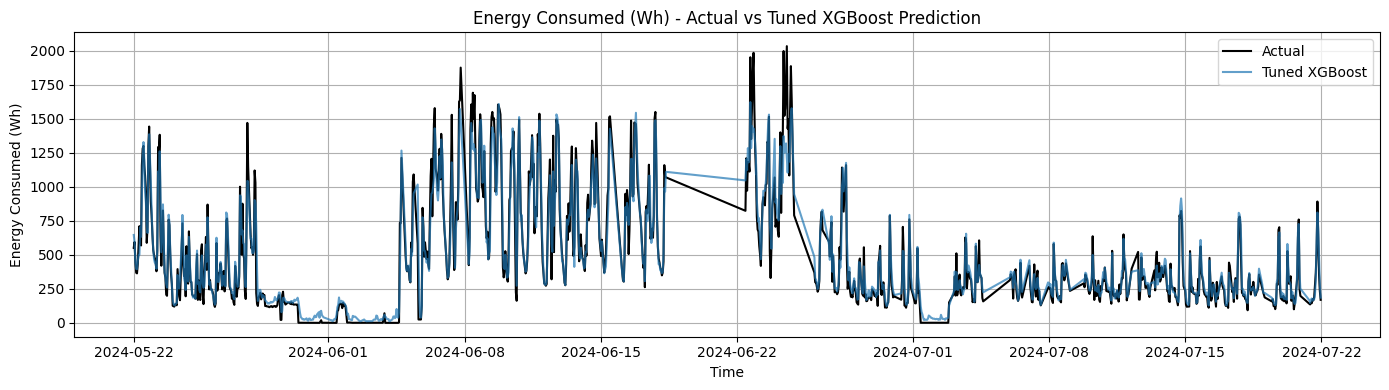

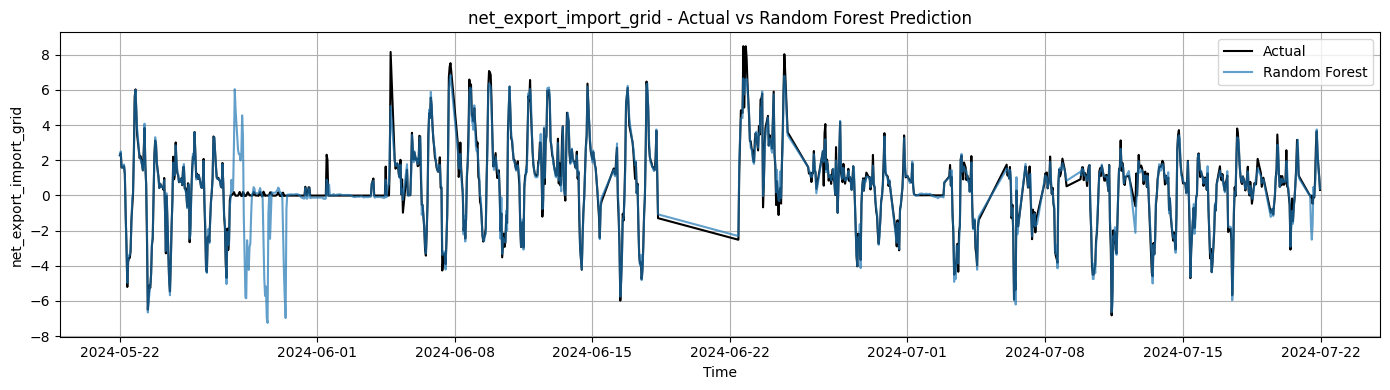

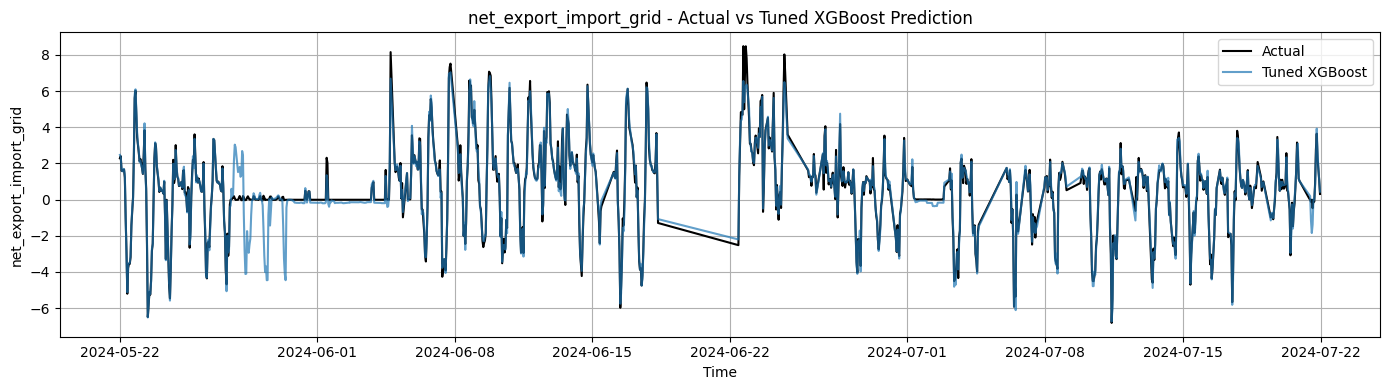

In [12]:
for res in results:
    plt.figure(figsize=(14, 4))
    plt.plot(res['y_test'].index, res['y_test'], label='Actual', color='black')
    plt.plot(res['y_test'].index, res['y_pred'], label=res['Model'], alpha=0.7)
    plt.title(f"{res['Target']} - Actual vs {res['Model']} Prediction")
    plt.xlabel("Time")
    plt.ylabel(res['Target'])
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [13]:

from sklearn.feature_selection import SelectKBest, f_regression

# For feature selection, we use the original dataset's reduced version
selected_features_dict = {}
X_selected_dict = {}

for target in targets:
    y = df[target]
    X_train, X_test = X_reduced.iloc[:split_idx], X_reduced.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    selector = SelectKBest(score_func=f_regression, k='all')
    selector.fit(X_train, y_train)
    scores = selector.scores_
    top_k_idx = scores.argsort()[-10:]  # selecting top 10 features
    selected_features = X_reduced.columns[top_k_idx].tolist()
    selected_features_dict[target] = selected_features
    X_selected_dict[target] = X_reduced[selected_features]


In [14]:

from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

best_models = {}

for target in targets:
    X = X_selected_dict[target]
    y = df[target]
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    xgb = XGBRegressor(random_state=42)
    param_grid = {
        "n_estimators": [100, 200],
        "max_depth": [3, 5, 7],
        "learning_rate": [0.01, 0.1],
        "subsample": [0.8, 1.0],
    }

    grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring="r2", verbose=0, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[target] = grid_search.best_estimator_


In [15]:

for target in targets:
    print(f"Final Evaluation (Feature Selected + Tuned XGBoost): {target}")
    X = X_selected_dict[target]
    y = df[target]
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    model = best_models[target]
    y_pred = model.predict(X_test)

    eval_result = evaluate_model(y_test, y_pred)
    eval_result.update({
        "Model": "Tuned XGBoost (Selected)",
        "Target": target,
        "y_test": y_test,
        "y_pred": y_pred
    })
    results.append(eval_result)


Final Evaluation (Feature Selected + Tuned XGBoost): Energy Produced (Wh)
Final Evaluation (Feature Selected + Tuned XGBoost): Energy Consumed (Wh)
Final Evaluation (Feature Selected + Tuned XGBoost): net_export_import_grid


In [16]:
results_df = pd.DataFrame(results)
results_df = results_df[['Target', 'Model', 'MAE', 'RMSE', 'SMAPE', 'R2']]
results_df.round(2)

,Target,Model,MAE,RMSE,SMAPE,R2
0,Energy Produced (Wh),Random Forest,63.41,152.83,79.66,0.92
1,Energy Produced (Wh),Tuned XGBoost,66.82,137.74,113.63,0.94
2,Energy Consumed (Wh),Random Forest,51.97,98.92,16.82,0.94
3,Energy Consumed (Wh),Tuned XGBoost,60.94,98.11,34.03,0.95
4,net_export_import_grid,Random Forest,0.32,0.78,47.42,0.88
5,net_export_import_grid,Tuned XGBoost,0.25,0.54,44.25,0.94
6,Energy Produced (Wh),Tuned XGBoost (Selected),57.37,115.61,113.28,0.96
7,Energy Consumed (Wh),Tuned XGBoost (Selected),44.56,86.71,29.77,0.96
8,net_export_import_grid,Tuned XGBoost (Selected),0.14,0.30,39.96,0.98


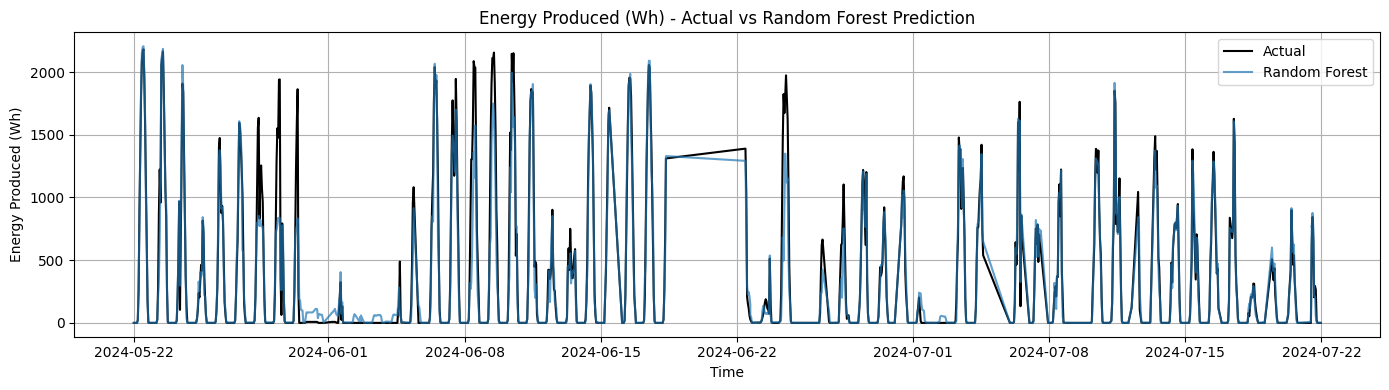

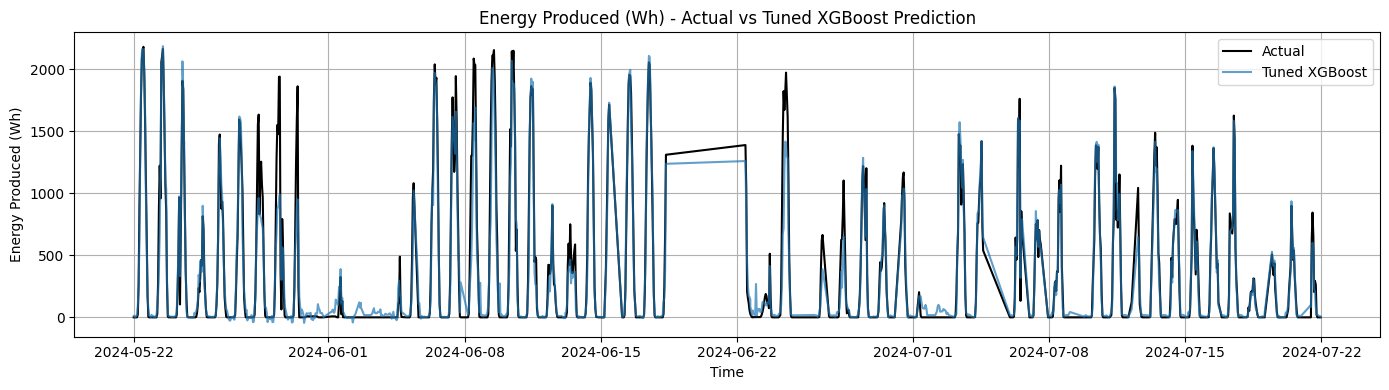

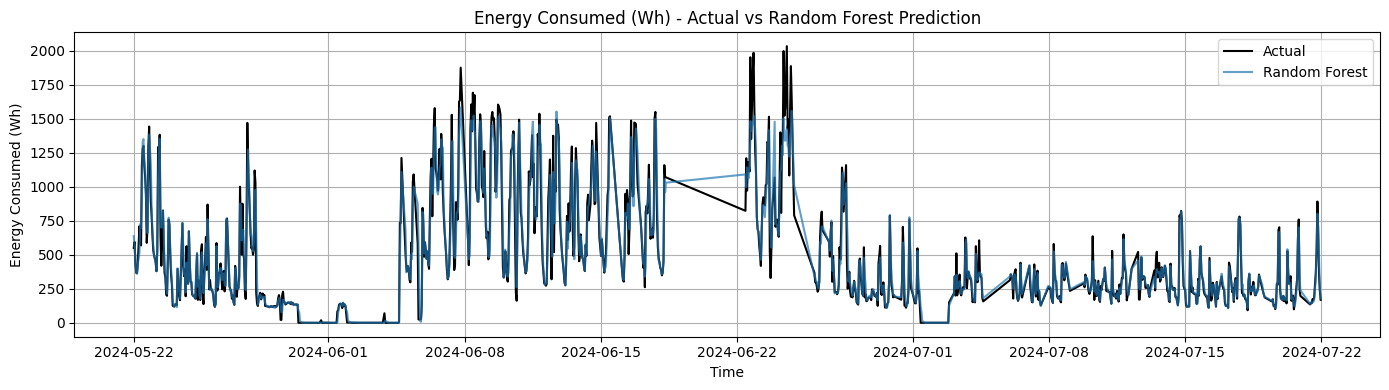

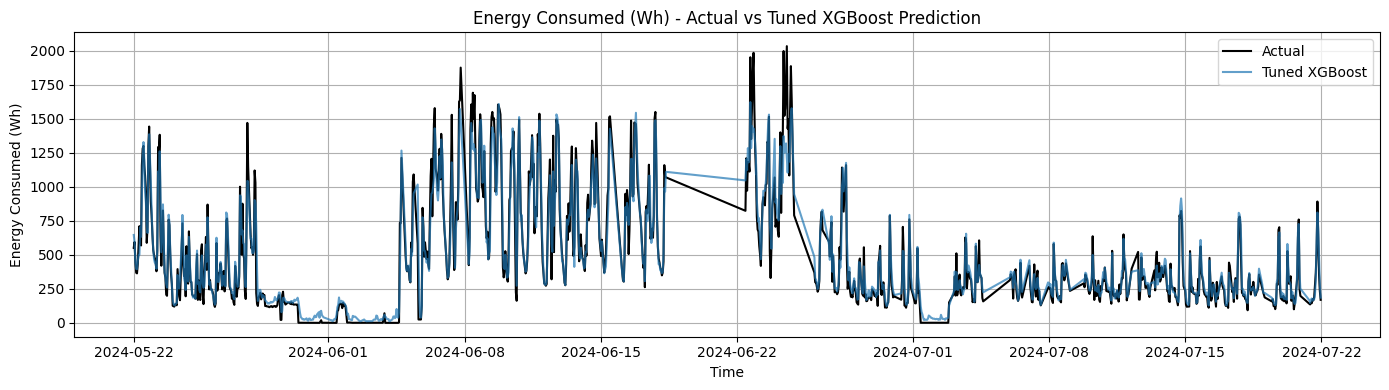

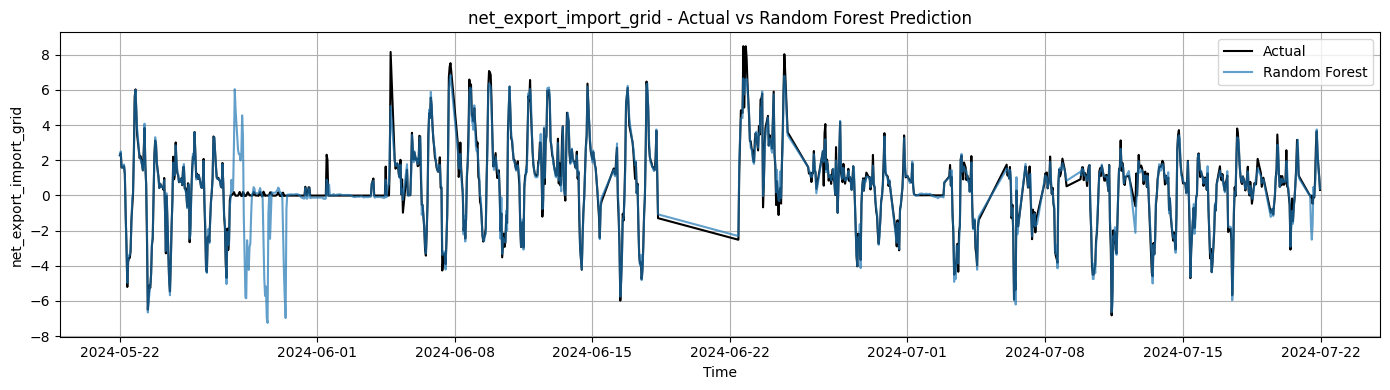

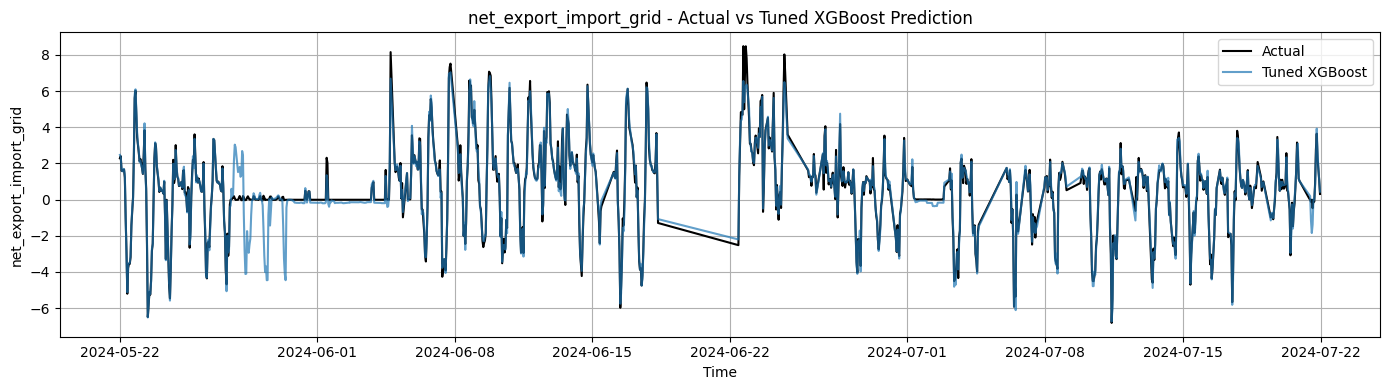

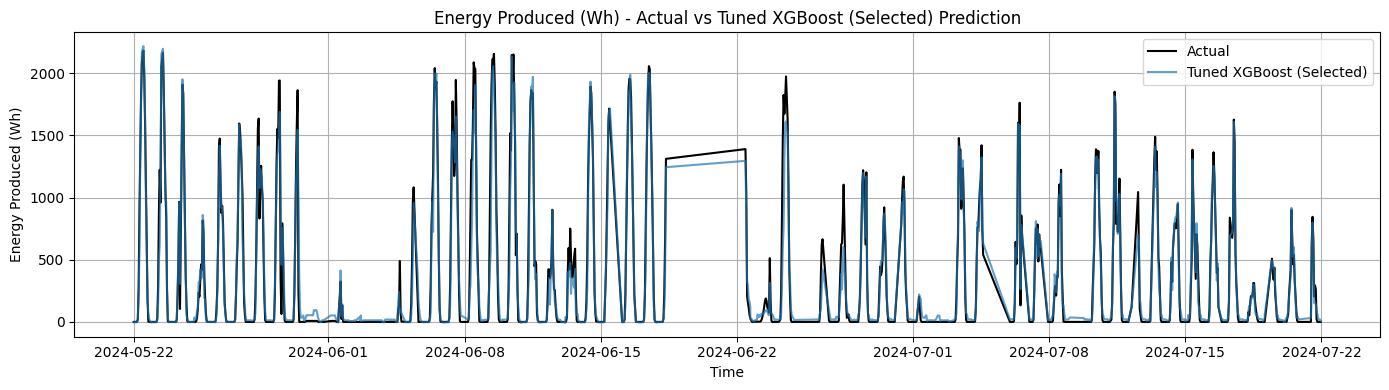

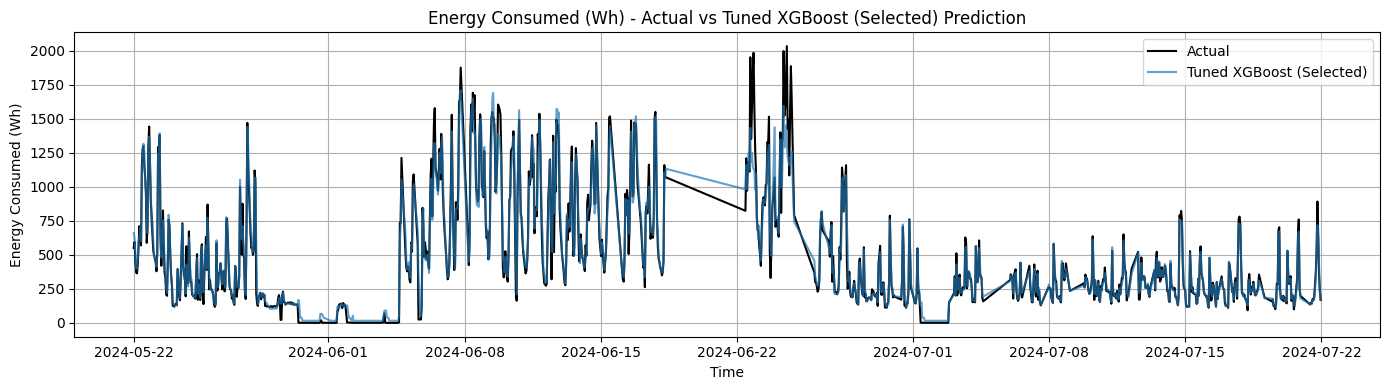

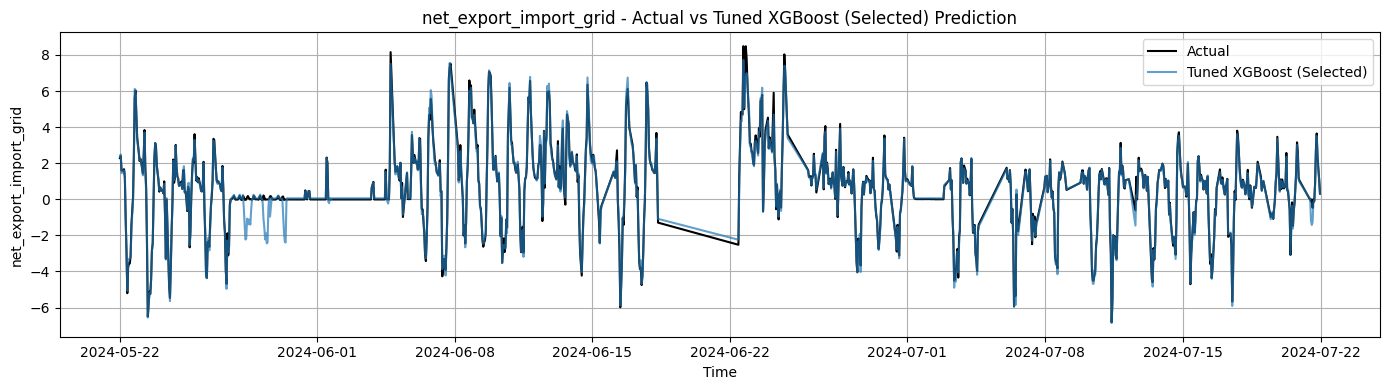

In [17]:
for res in results:
    plt.figure(figsize=(14, 4))
    plt.plot(res['y_test'].index, res['y_test'], label='Actual', color='black')
    plt.plot(res['y_test'].index, res['y_pred'], label=res['Model'], alpha=0.7)
    plt.title(f"{res['Target']} - Actual vs {res['Model']} Prediction")
    plt.xlabel("Time")
    plt.ylabel(res['Target'])
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
